# Team rADAtouille - Milestone 2

This notebook aims to preprocess our data, and estimate the feasibility of the different ideas we had during the first milestone, using data exploration and some preliminary analysis.

On today's menu:
- [Dataset description](#Dataset-description)
- [Data loading](#Data-loading)
- [Initial dataset preprocessing](#Data-preprocessing)
    - [Characters dataset](#Characters-dataset) 
    - [Movies dataset](#Movies-dataset)
    - [Plot summaries dataset](#Plot-summaries-dataset)
- [External datasets](#External-datasets)
    - [Scrapping Data](#Scrapping-Data)
    - [Scrapped Data Preprocessing](#Scrapped-Data-Preprocessing)
- [Data merging](#Data-merging)
- [Data exploration](#Data-exploration)

# Datasets description

This project utilizes a rich collection of datasets encompassing movies, characters, and plot summaries. The primary datasets include:

- **Characters Dataset** (`character.metadata.tsv`): Contains detailed metadata on movie characters and the actors portraying them. Key attributes include Wikipedia and Freebase IDs, movie release dates, character names, actor birthdates, genders, heights, ethnicities, and ages at the time of movie release.

- **Movies Dataset** (`movie.metadata.tsv`) Includes comprehensive information about movies. It features data such as Wikipedia and Freebase IDs, movie names, release dates, box office revenues, runtimes, languages, countries, and genres.

- **Plot Summaries Dataset** (`plot_summaries.text`): Offers a concise summary of movie plots, linked to movies through Wikipedia movie IDs.

### External datasets

We also use external datasets to enrich our data. More information about these datasets can be found in the [External datasets](#External-datasets) section.

- **IMDB Users Ratings** (`title.ratings.tsv`): Contains the IMDB number of votes and the average rating for each movie.

- **Metacritic Critics Ratings** (`metacritic_reviews.csv`): Contains the Metacritic critics rating for each movie with the metascore, publisher and author.

- **Awards** (`awards.csv`): Contains the awards nominations and wins for each movie.


# Initial dataset preprocessing

## Characters dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import requests
import urllib

In [2]:
# Load the data
df_characters = pd.read_table('data/raw/character.metadata.tsv', names=['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age_at_movie_release', 'freebase_actor_map_id', 'freebase_character_id', 'freebase_actor_id'])
df_characters.head()

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


Let's check if we can find some missing values in the dataset.

In [3]:
df_characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   wikipedia_id                450669 non-null  int64  
 1   freebase_id                 450669 non-null  object 
 2   release_date                440674 non-null  object 
 3   character_name              192794 non-null  object 
 4   actor_dob                   344524 non-null  object 
 5   actor_gender                405060 non-null  object 
 6   actor_height                154824 non-null  float64
 7   actor_ethnicity             106058 non-null  object 
 8   actor_name                  449441 non-null  object 
 9   actor_age_at_movie_release  292556 non-null  float64
 10  freebase_actor_map_id       450669 non-null  object 
 11  freebase_character_id       192804 non-null  object 
 12  freebase_actor_id           449854 non-null  object 
dtypes: float64(2),

We can identify from the output above that:
- There are some *missing values*
- Some *type are not exploitable* (e.g. the `release_date` and `actor_dob`  are `object`s, not exploitable dates)

We  first tackle the type problem by converting the `object` type to `datetime` type.

In [4]:
df_characters['release_date'].sample(10)

262770    1948-12-25
375114          2003
187360          1928
198963    2000-09-09
283783          1983
61409           1999
104628          1961
15593           2012
99037           1991
328010          1958
Name: release_date, dtype: object

In [5]:
# If the date string is only year, we put the first of january as the date
df_characters['actor_dob_datetime'] = df_characters['actor_dob'].astype(object).str.replace(r'^(\d{4})$', r'\1-01-01', regex=True)
df_characters['release_date_datetime'] = df_characters['release_date'].astype(object).str.replace(r'^(\d{4})$', r'\1-01-01', regex=True)

# Convert the date strings to datetime objects
df_characters['actor_dob_datetime'] = pd.to_datetime(df_characters['actor_dob_datetime'], errors='coerce')
df_characters['release_date_datetime'] = pd.to_datetime(df_characters['release_date'], errors='coerce')

print('Have lost %d release dates'%(df_characters['release_date_datetime'].isna().sum() - df_characters['release_date'].isna().sum()), 'now there are %d missing'%(df_characters['release_date_datetime'].isna().sum()))
print('Have lost %d birth dates'%(df_characters['actor_dob_datetime'].isna().sum() - df_characters['actor_dob'].isna().sum()), 'now there are %d missing'%(df_characters['actor_dob_datetime'].isna().sum()))

Have lost 166802 release dates now there are 176797 missing
Have lost 774 birth dates now there are 106919 missing


Concerning the *missing values* problem, we have 3 options: not using the problematic columns, dropping the rows or filling the missing values using external source.

Now we'll take a look at the values and see if we can find some outliers.

In [6]:
df_characters.describe(include='all')

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_actor_map_id,freebase_character_id,freebase_actor_id,actor_dob_datetime,release_date_datetime
count,4.506690e+05,450669,440674,192794,344524,405060,154824.000000,106058,449441,292556.000000,450669,192804,449854,343750,273872
unique,NaN,64330,18476,126629,29494,2,NaN,479,134078,NaN,450669,183435,135760,NaN,NaN
top,NaN,/m/0cc8620,2008,Doctor,1908-05-30,M,NaN,/m/0dryh9k,Mel Blanc,NaN,/m/0bgchxw,/m/0h577m2,/m/0c5vh,NaN,NaN
freq,NaN,115,5453,198,791,270257,NaN,16351,791,NaN,1,146,791,NaN,NaN
mean,1.396975e+07,NaN,NaN,NaN,NaN,NaN,1.788893,NaN,NaN,37.788523,NaN,NaN,NaN,1943-08-12 02:19:09.947345408,1986-03-21 01:35:51.124612800
min,3.300000e+02,NaN,NaN,NaN,NaN,NaN,0.610000,NaN,NaN,-7896.000000,NaN,NaN,NaN,1796-09-20 00:00:00,1894-11-17 00:00:00
25%,3.759292e+06,NaN,NaN,NaN,NaN,NaN,1.676400,NaN,NaN,28.000000,NaN,NaN,NaN,1923-01-20 00:00:00,1971-05-26 00:00:00
50%,1.189065e+07,NaN,NaN,NaN,NaN,NaN,1.750000,NaN,NaN,36.000000,NaN,NaN,NaN,1948-05-10 12:00:00,1997-04-04 00:00:00
75%,2.366501e+07,NaN,NaN,NaN,NaN,NaN,1.830000,NaN,NaN,47.000000,NaN,NaN,NaN,1966-08-15 00:00:00,2006-09-05 00:00:00
max,3.750192e+07,NaN,NaN,NaN,NaN,NaN,510.000000,NaN,NaN,103.000000,NaN,NaN,NaN,2050-01-01 00:00:00,2016-06-08 00:00:00


Uh, we can find a few interesting results:
- How can an actors' height be 510m ? 
- How can an actor's age be negative ?

Let's first take a look at the corresponding row for the heigh

In [7]:
df_characters[df_characters['actor_height'] > 2.5]

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_actor_map_id,freebase_character_id,freebase_actor_id,actor_dob_datetime,release_date_datetime
21619,1291587,/m/04qk12,2004-09-01,young Georgie,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,18.0,/m/0k276dx,/m/0k276dz,/m/0bggwvl,1986-03-13,2004-09-01
49659,30865068,/m/02ml14,1998-10-15,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0n9ld0y,NaN,/m/08hqh0,1972-12-06,1998-10-15
59719,12206655,/m/02vvw24,NaN,Dominic,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,NaN,/m/0k276dq,/m/0h8hcr1,/m/0bggwvl,1986-03-13,NaT
104140,17999628,/m/047n_2q,1998,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0cg31bd,NaN,/m/08hqh0,1972-12-06,NaT
205679,1373475,/m/04xmx8,2003-08-15,Jackal Johnson,1972-12-06,M,510.0,NaN,Vince Corazza,30.0,/m/02vbm0k,/m/0h60xk7,/m/08hqh0,1972-12-06,2003-08-15
219383,179326,/m/018gq3,1996-11-18,Herbert,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,10.0,/m/0bggwv8,/m/0bggwvc,/m/0bggwvl,1986-03-13,1996-11-18
301653,4667507,/m/0cg9n6,2001-11-29,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,28.0,/m/0cg0zwp,NaN,/m/08hqh0,1972-12-06,2001-11-29
316621,3915041,/m/0b6lyp,2002,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,29.0,/m/02vc5p5,NaN,/m/08hqh0,1972-12-06,NaT
341890,29290087,/m/0b3w9mr,1997-04-07,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,24.0,/m/0gvwy8x,NaN,/m/08hqh0,1972-12-06,1997-04-07
360967,14413223,/m/03d2rnl,2012-04-20,Young Punk Guy,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,26.0,/m/0m4q87d,/m/0k9tfs8,/m/0bggwvl,1986-03-13,2012-04-20


Using a few google searches, we found that for the 510.0m problem, the actor's height is 5'10" (1.78m). We'll fix this value.
Concerning the 180m problem, we can guess that the actor's height is 1.80m, but we can't find any source to confirm this (internet or other rows). We'll drop these row (4).

In [8]:
df_characters.drop(df_characters[df_characters['actor_height'] > 2.5].index, inplace=True)

Let's then take care of the age problem.

In [9]:
print(df_characters.loc[(df_characters['actor_age_at_movie_release'] < 0)].shape[0], 'such rows are concerned')
df_characters = df_characters[df_characters['actor_age_at_movie_release'] > 0]

381 such rows are concerned


In [10]:
# Count the number of actor born after the movie release
df_characters[df_characters['actor_dob_datetime'] > df_characters['release_date_datetime']].shape[0]

0

This hence not a problem! We also look for duplicates.

In [11]:
# Drop the rows that have duplicates
df_characters.drop_duplicates(subset=['freebase_id', 'freebase_actor_id', 'freebase_character_id'], inplace=True)

### Save the processed dataset

In [12]:
# Drop the columns that are not useful
df_characters.drop(columns=['actor_dob', 'release_date'], inplace=True)

# Save the processed data
df_characters.to_csv('data/processed/character.metadata.processed.tsv', sep='\t', index=False)

## Movie dataset

In [16]:
# For the movies metadata
df_movies = pd.read_table('data/raw/movie.metadata.tsv', names=['wikipedia_id', 'freebase_id', 'name', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres'], header=None)

In [17]:
print(df_movies.info())

#check for NaN values for each columns
print('\nCheck for NaN values:')
print(df_movies.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wikipedia_id  81741 non-null  int64  
 1   freebase_id   81741 non-null  object 
 2   name          81741 non-null  object 
 3   release_date  74839 non-null  object 
 4   revenue       8401 non-null   float64
 5   runtime       61291 non-null  float64
 6   languages     81741 non-null  object 
 7   countries     81741 non-null  object 
 8   genres        81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB
None

Check for NaN values:
wikipedia_id        0
freebase_id         0
name                0
release_date     6902
revenue         73340
runtime         20450
languages           0
countries           0
genres              0
dtype: int64


In [18]:
#Check for duplicate entries
print('Check for duplicate entries:')
print(df_movies.duplicated().sum())

#Check for duplicate entries with name only
print('Check for duplicate entries with name only:')
print(df_movies.duplicated(subset=['name']).sum())

#Check for duplicate entries with name and date release only
print('Check for duplicate entries with name and date release:')
print(df_movies.duplicated(subset=['name', 'release_date']).sum())

#Check for duplicate entries with name and date release only
print('Check for duplicate entries with name and movie runtime:')
print(df_movies.duplicated(subset=['name', 'runtime']).sum())

#Check for duplicate entries with name and date release only
print('Check for duplicate entries with wikipedia ID:')
print(df_movies.duplicated(subset=['wikipedia_id']).sum())

Check for duplicate entries:
0
Check for duplicate entries with name only:
6263
Check for duplicate entries with name and date release:
103
Check for duplicate entries with name and movie runtime:
628
Check for duplicate entries with wikipedia ID:
0


We have some duplicate entries on the name but the wikipedia ID is always unique

In [19]:
df_movies.describe(include='all')

,wikipedia_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres
count,8.174100e+04,81741,81741,74839,8.401000e+03,6.129100e+04,81741,81741,81741
unique,NaN,81741,75478,20389,NaN,NaN,1817,2124,23817
top,NaN,/m/03vyhn,Alice in Wonderland,2006,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
freq,NaN,1,17,1011,NaN,NaN,33748,30300,6851
mean,1.740784e+07,NaN,NaN,NaN,4.799363e+07,1.118192e+02,NaN,NaN,NaN
std,1.098791e+07,NaN,NaN,NaN,1.121753e+08,4.360070e+03,NaN,NaN,NaN
min,3.300000e+02,NaN,NaN,NaN,1.000000e+04,0.000000e+00,NaN,NaN,NaN
25%,7.323695e+06,NaN,NaN,NaN,2.083193e+06,8.100000e+01,NaN,NaN,NaN
50%,1.777899e+07,NaN,NaN,NaN,1.063969e+07,9.300000e+01,NaN,NaN,NaN
75%,2.715573e+07,NaN,NaN,NaN,4.071696e+07,1.060000e+02,NaN,NaN,NaN


Looking at the output, we may have a few observations:
- Is there a problem with the `release_date` column ? There is at least one entry with a date in the future compared to when the dataset was released.
- 2B in box office revenue seems a bit excessive, according to Google the max is around 380M$. 
- The `runtime` column seems to have some outliers, with at least one movie with a runtime of 0, and one of 1 million minutes (multiple months).

### Release date

We have a similar date problem as the one we had with the characters dataset. We'll fix it the same way.

In [20]:
# If the date string is only year, we put the first of january as the date
df_movies['release_date_datetime'] = df_movies['release_date'].astype(object).str.replace(r'^(\d{4})$', r'\1-01-01', regex=True)

# Convert the date strings to datetime objects
df_movies['release_date_datetime'] = pd.to_datetime(df_movies['release_date'], errors='coerce')

print('Have lost %d release dates'%(df_movies['release_date_datetime'].isna().sum() - df_movies['release_date'].isna().sum()), 'now there are %d missing'%(df_movies['release_date_datetime'].isna().sum()))

Have lost 35467 release dates now there are 42369 missing


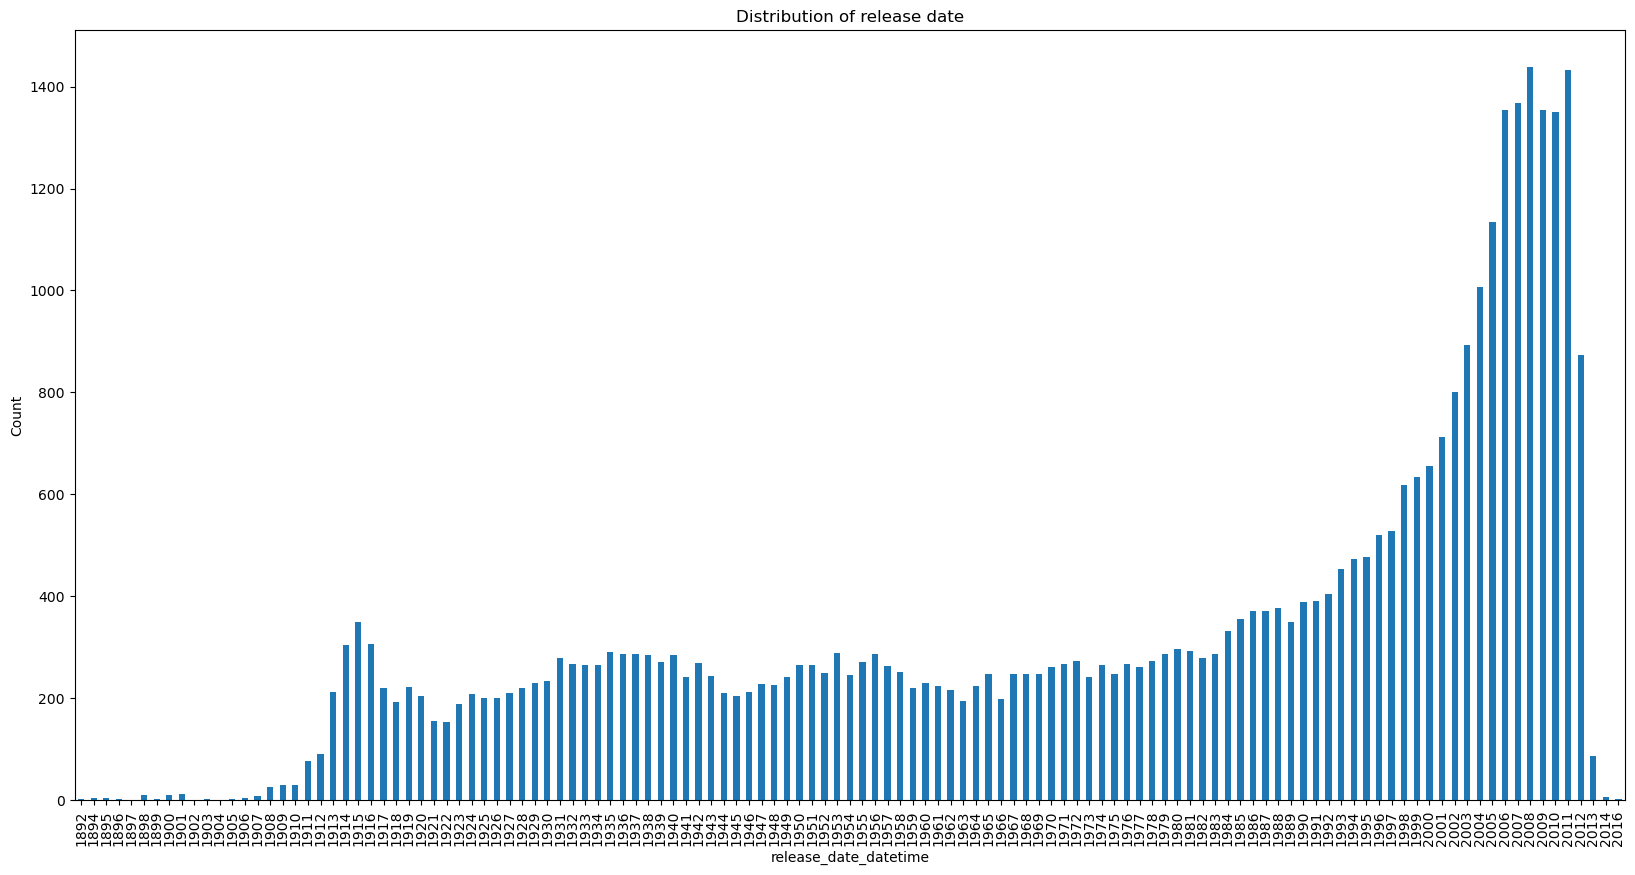

In [21]:
# Plot the distribution of the movie release date
plt.figure(figsize=(20, 10))
plt.title('Distribution of release date')
plt.xlabel('Release date')
plt.ylabel('Count')
df_movies.dropna(subset=['release_date_datetime'])['release_date_datetime'].dt.year.sort_values().value_counts(sort=False).plot(kind='bar')
plt.show()

In [22]:
print(f"There are {df_movies[df_movies['release_date_datetime'] >= pd.to_datetime('2014')].shape[0]} movies are after 2014:")
df_movies[df_movies['release_date_datetime'] >= pd.to_datetime('2014')]

There are 8 movies are after 2014:


,wikipedia_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,release_date_datetime
2768,35343769,/m/0j9qc6b,Gokula Krishna,2014-04-02,NaN,NaN,{},{},"{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",2014-04-02
30275,27554912,/m/0c03gcc,Kung Fu Panda 3,2016-03-18,NaN,NaN,{},{},{},2016-03-18
34022,23124260,/m/064mmw7,Jeepers Creepers 4,2016-06-08,NaN,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""}",2016-06-08
34454,35764246,/m/0jt01_6,Appayya,2014-08-15,NaN,NaN,"{""/m/09bnf"": ""Kannada Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film""}",2014-08-15
34896,36534974,/m/0kdy118,Noah,2014-03-28,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01hmnh"": ""Fantasy""}",2014-03-28
54999,36127934,/m/0k0tq97,Maleficent,2014-03-14,NaN,NaN,{},{},"{""/m/01hmnh"": ""Fantasy""}",2014-03-14
70420,34228489,/m/0hzml4n,Hosa Prema Purana,2014-12-30,NaN,NaN,"{""/m/09bnf"": ""Kannada Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film""}",2014-12-30
76661,36034066,/m/0j_7nzk,Invertigo,2014-03-07,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0cq22z7"": ""Sci-Fi Horror""}",2014-03-07


We can see that there are 24 occurence of movies that were released after the release of the dataset. In order to have a more representative dataset, we'll drop these rows.

In [23]:
old_shape = df_movies.shape[0]
df_movies.drop(df_movies[df_movies['release_date_datetime'] >= pd.to_datetime('2014')].index, inplace=True)
print(f"Have removed {old_shape - df_movies.shape[0]} movies")

Have removed 8 movies


### Runtime

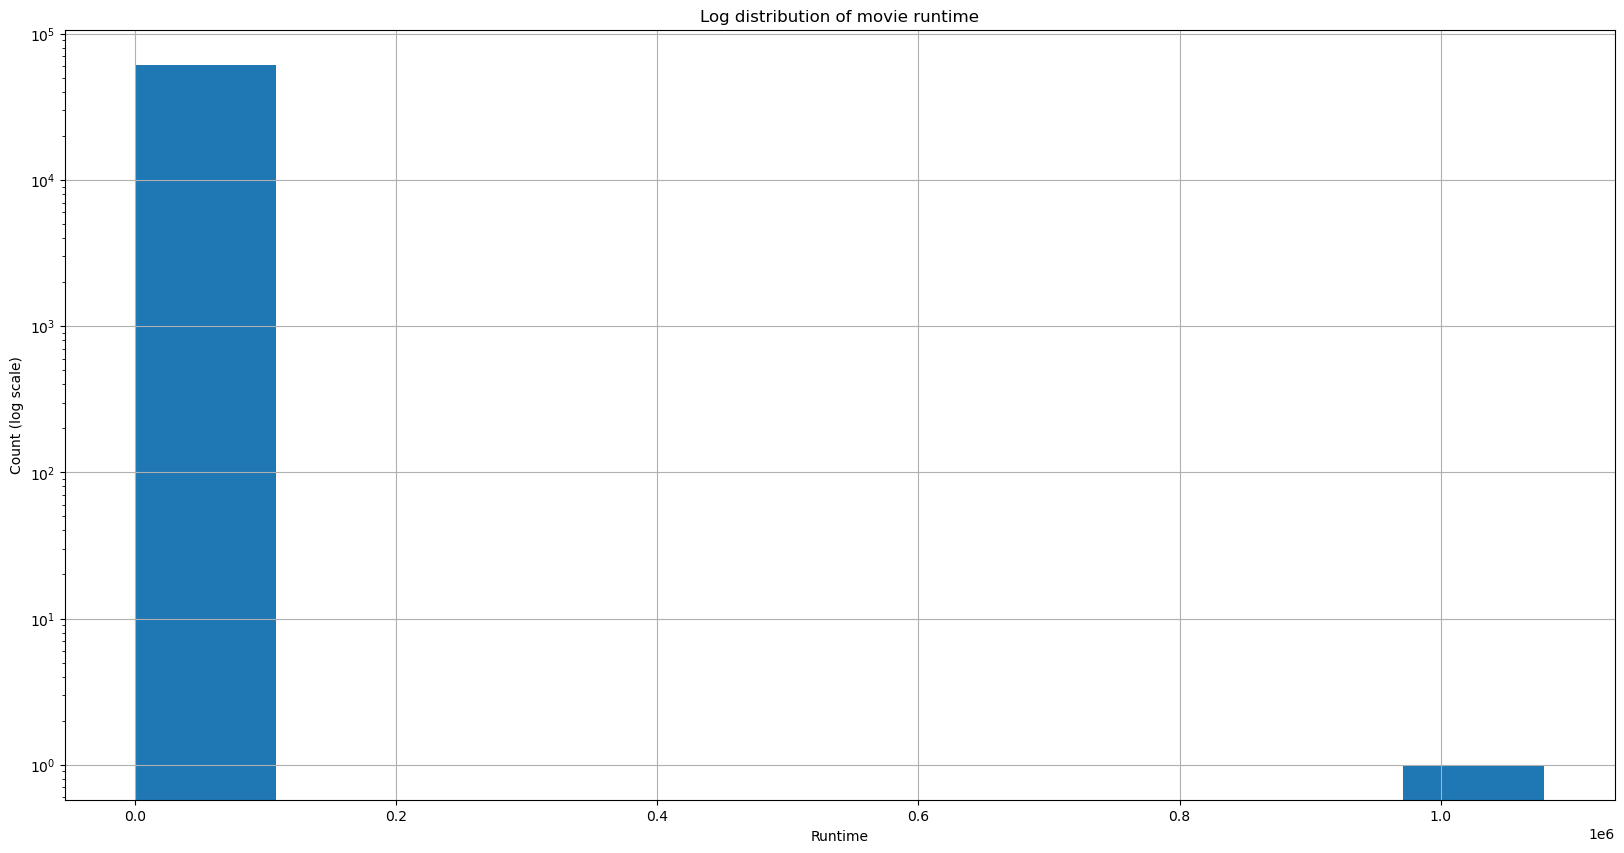

In [24]:
# Plot the distribution of the movie runtime
plt.figure(figsize=(20,10))
plt.title('Log distribution of movie runtime')
plt.xlabel('Runtime')
plt.ylabel('Count (log scale)')
plt.yscale('log')
df_movies.dropna(subset=['runtime'])['runtime'].hist(bins=10)
plt.show()

We can see that there are some outliers in the runtime column. We'll drop the rows with a runtime less or equal to 0 and greater than 500 minutes. 

In [25]:
old_shape = df_movies.shape[0]
df_movies.drop(df_movies[df_movies['runtime'] > 500].index, inplace=True)
df_movies.drop(df_movies[df_movies['runtime'] <= 0].index, inplace=True)
print(f"Have lost {old_shape - df_movies.shape[0]} rows")

Have lost 47 rows


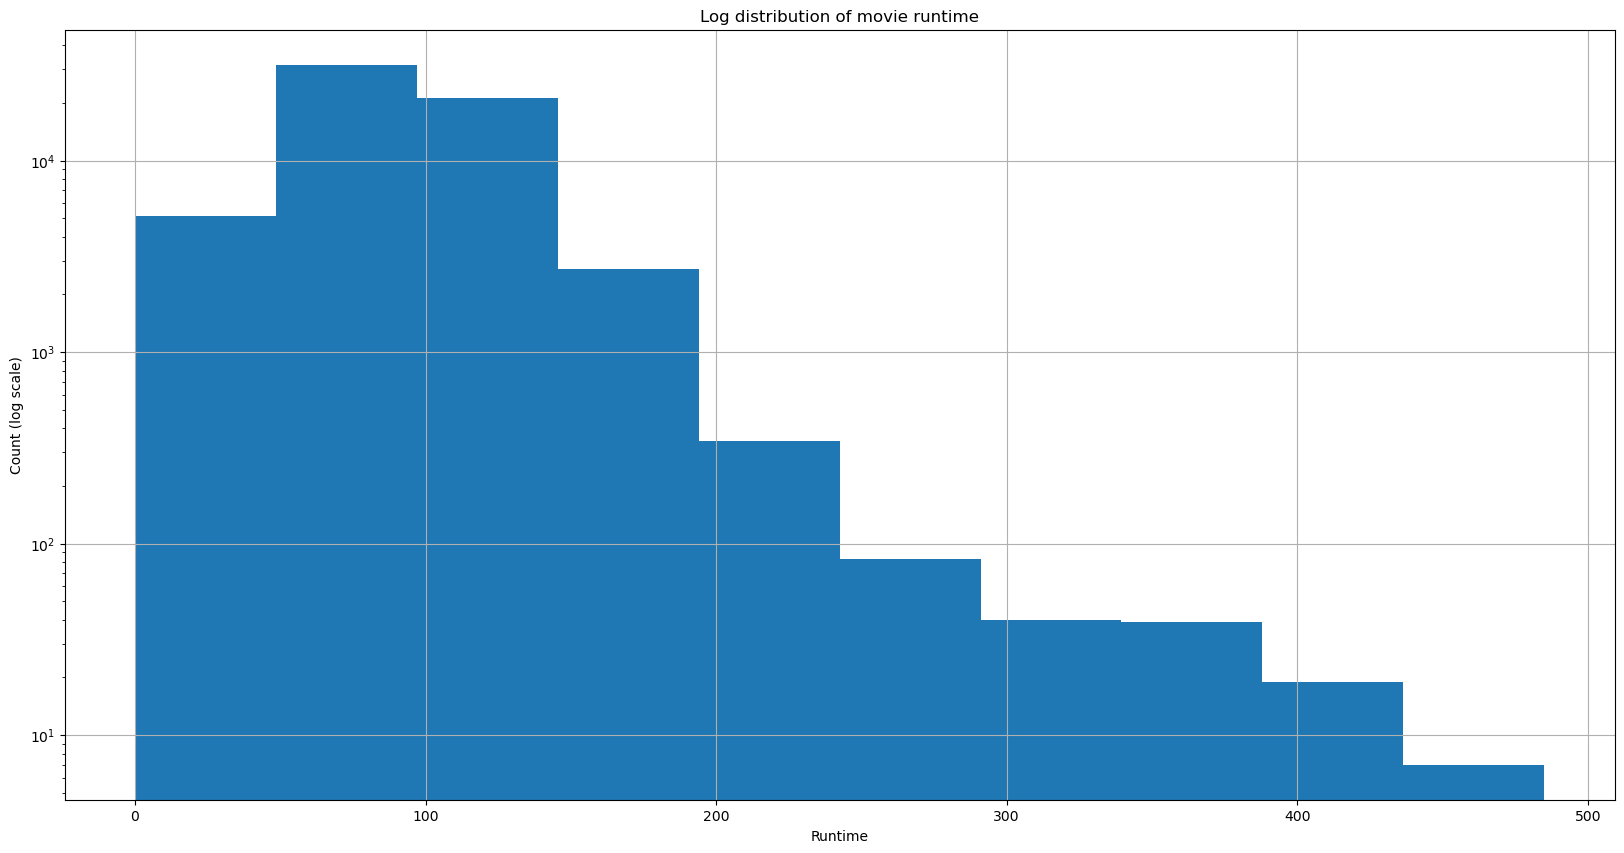

In [26]:
plt.figure(figsize=(20,10))
plt.title('Log distribution of movie runtime')
plt.xlabel('Runtime')
plt.ylabel('Count (log scale)')
plt.yscale('log')
df_movies.dropna(subset=['runtime'])['runtime'].hist(bins=10)
plt.show()

### Genres

We can see that the `genres` column is a dict of genres. We'll explode this column to have a row for each genre.

In [27]:
def extract_list(row, type):
    '''
    Extract the list of values from a dictionary
    
    Params:
    - row (pandas.Series): the row of the dataframe
    - type (str): the type of the column to explode

    Return: the list of the values of the dictionary

    '''
    try:
        values_dict = ast.literal_eval(row[type])
        return list(values_dict.values())
    except:
        return []

In [28]:
# Extract the list of genres
df_movies['extracted_genres'] = df_movies.apply(lambda row: extract_list(row, 'genres'), axis=1)

# Explode the genres
df_movies_exploded = df_movies.explode('extracted_genres')

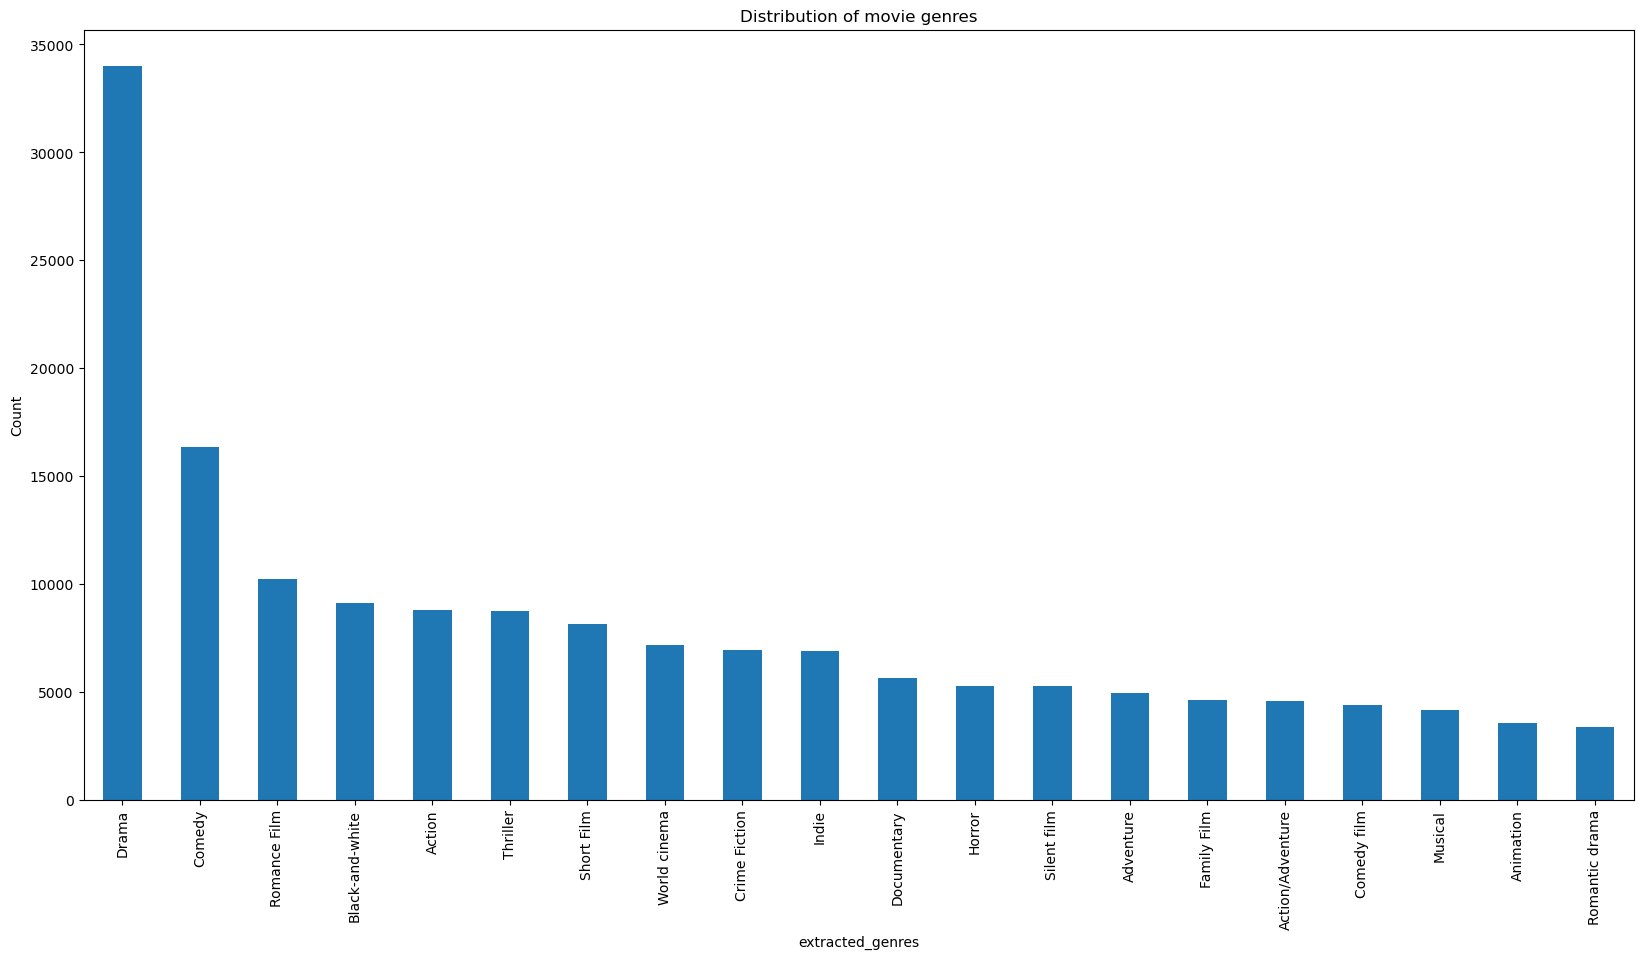

In [29]:
# Plot the distribution of movie genres, for the top 20 genres
plt.figure(figsize=(20,10))
plt.title('Distribution of movie genres')
plt.xlabel('Movie genres')
plt.ylabel('Count')
df_movies_exploded['extracted_genres'].value_counts().head(20).plot(kind='bar')
plt.show()

### Countries

Similarly to the `genres` column, the `countries` column is a dict of countries. We'll explode this column to have a row for each country.

In [30]:
# Extract the list of countries
df_movies['extracted_countries'] = df_movies.apply(lambda row: extract_list(row, 'countries'), axis=1)

# Explode the countries
df_movies_exploded = df_movies.explode('extracted_countries')

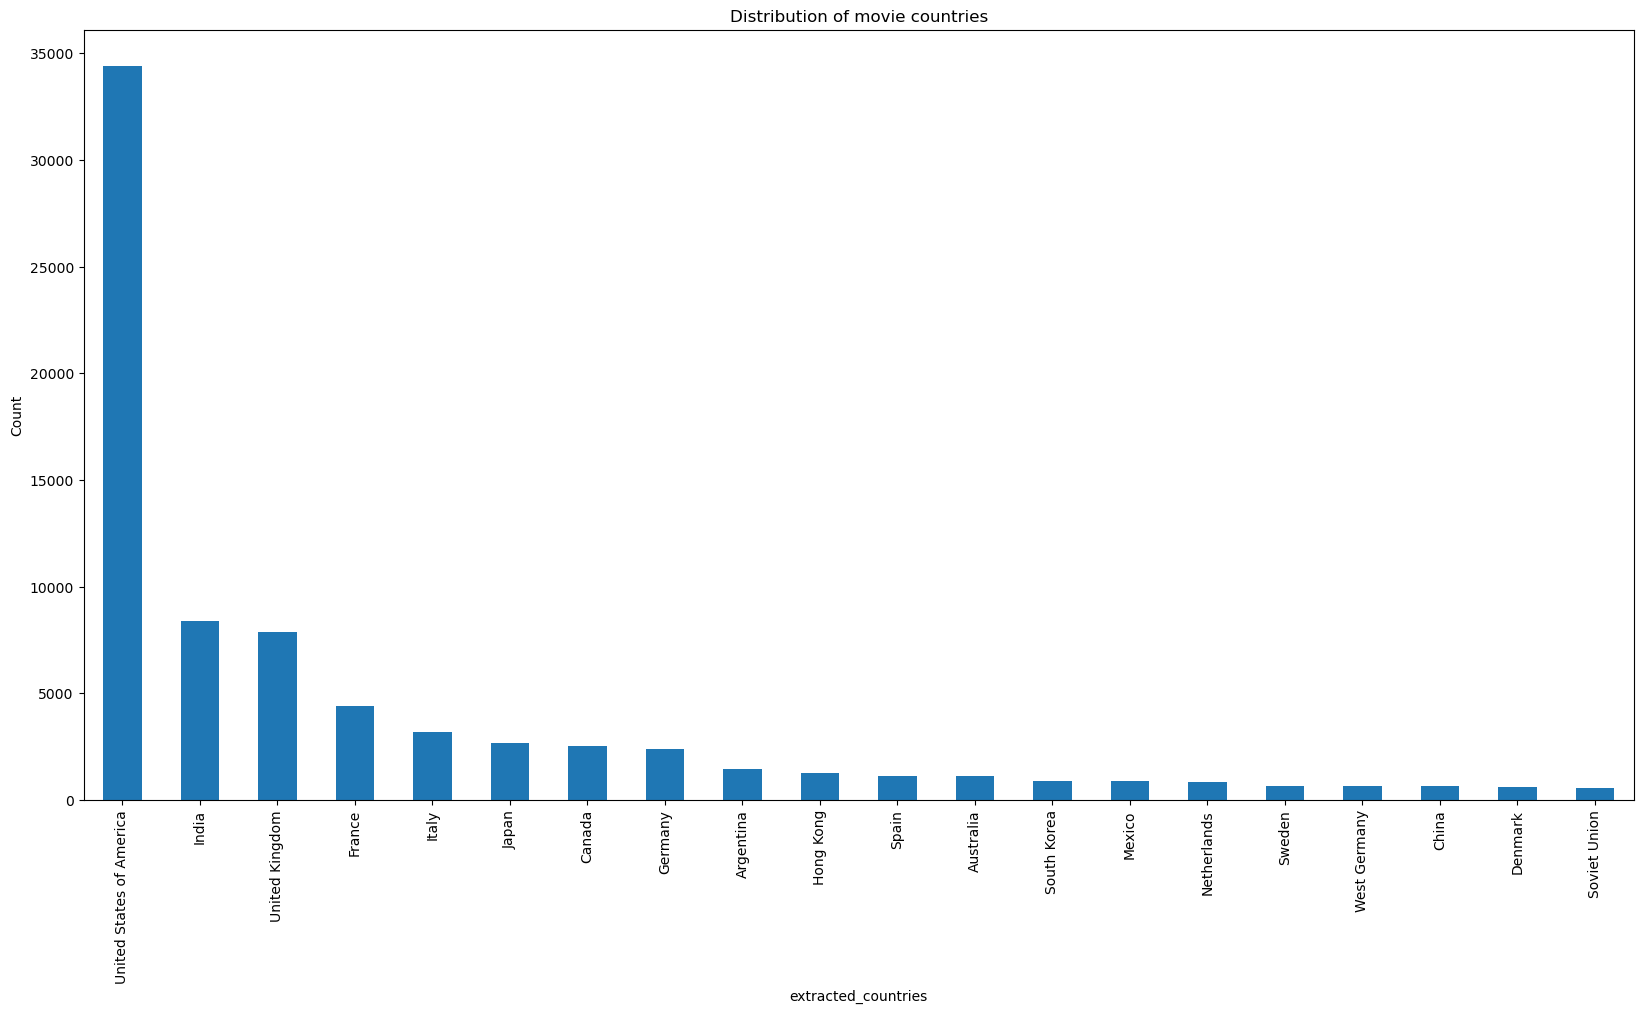

In [31]:
# Plot the distribution of movie countries, for the top 20 countries
plt.figure(figsize=(20,10))
plt.title('Distribution of movie countries')
plt.xlabel('Movie countries')
plt.ylabel('Count')
df_movies_exploded['extracted_countries'].value_counts().head(20).plot(kind='bar')
plt.show()

We can see that the USA is by far the most represented country in the dataset, followed by the UK and France.

### Languages

Similarly to the `genres` column, the `languages` column is a dict of languages. We'll explode this column to have a row for each language.

In [32]:
# Extract the list of languages
df_movies['extracted_languages'] = df_movies.apply(lambda row: extract_list(row, 'languages'), axis=1)

# Explode the languages
df_movies_exploded = df_movies.explode('extracted_languages')

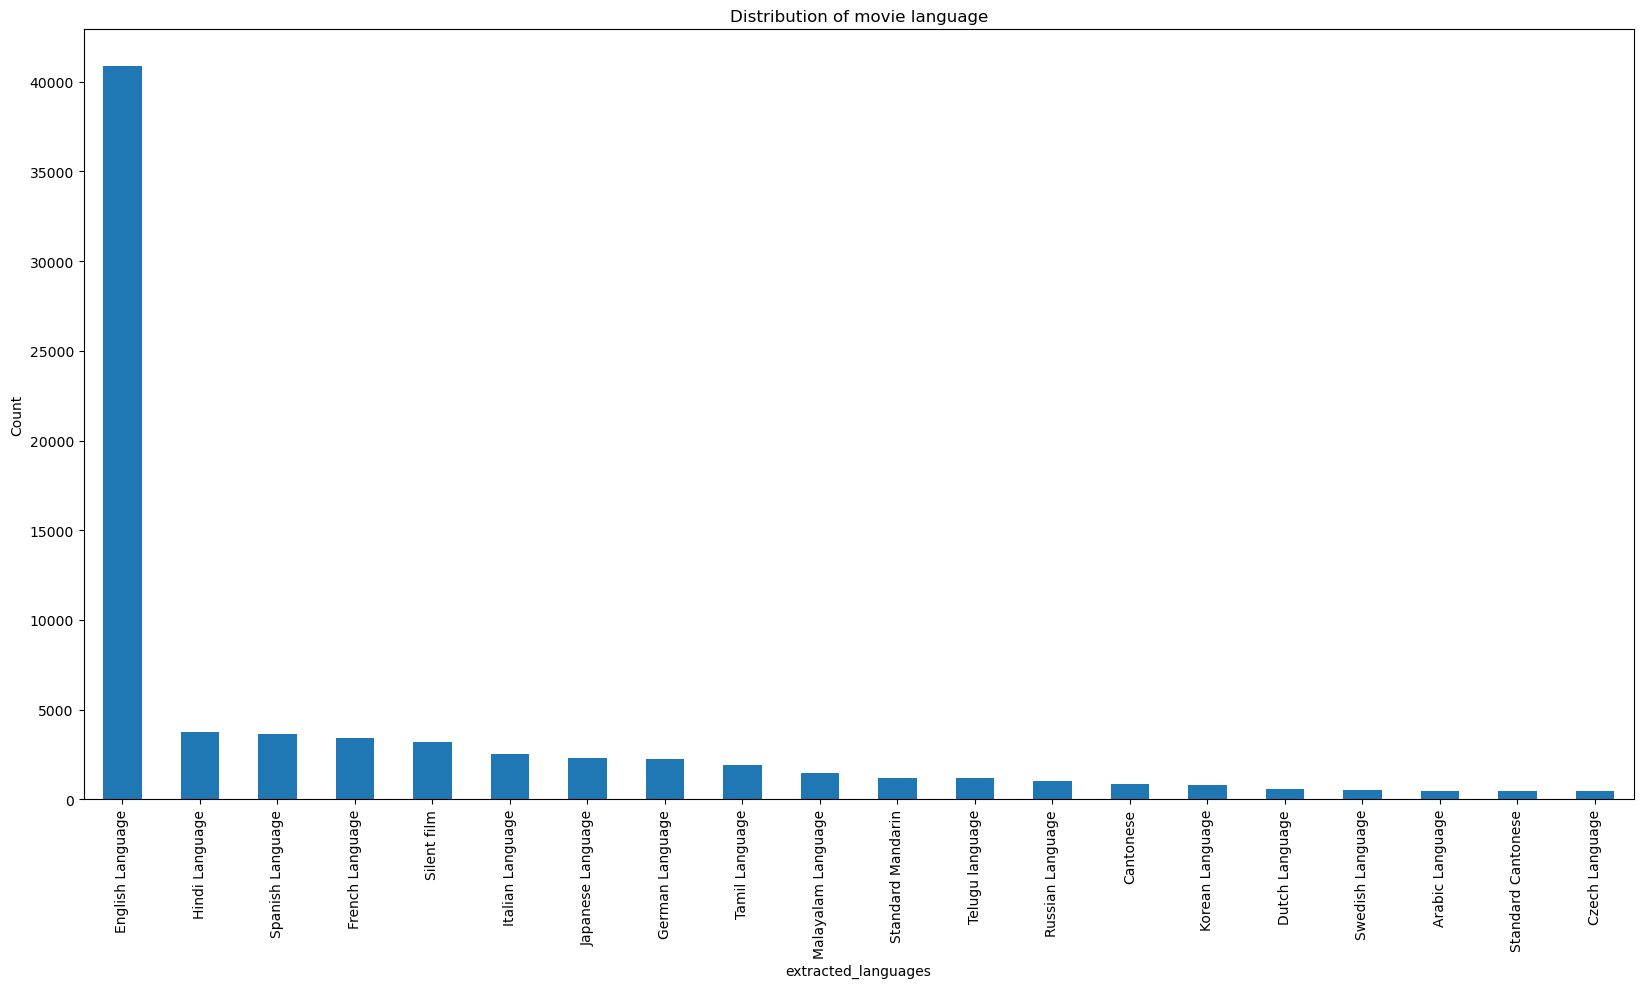

In [33]:
# Plot the distribution of movie language, for the top 20 languages
plt.figure(figsize=(20,10))
plt.title('Distribution of movie language')
plt.xlabel('Movie language')
plt.ylabel('Count')
df_movies_exploded['extracted_languages'].value_counts().head(20).plot(kind='bar')
plt.show()

We can see that English is by far the most represented language in our dataset.

### Save the processed dataset

In [34]:
# Save the processed dataframe
df_movies.to_csv('data/processed/movie.metadata.processed.tsv', sep='\t', index=False)

## Plot summaries dataset

In [36]:
# For the plot summaries
df_plots = pd.read_table('data/raw/plot_summaries.txt', names=['wikipedia_id', 'plot_summary'], header=None)

In [37]:
df_plots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   wikipedia_id  42303 non-null  int64 
 1   plot_summary  42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB


In [38]:
print(f"There are {df_plots.duplicated(subset=['plot_summary']).sum()} duplicated plot summaries:")
df_plots[df_plots.duplicated(subset=['plot_summary'])]

There are 8 duplicated plot summaries:


,wikipedia_id,plot_summary
14631,14055212,A woman is thrown out of her home by her jealo...
29428,14022275,A woman is thrown out of her home by her jealo...
30987,14051944,A woman is thrown out of her home by her jealo...
31702,14053389,A woman is thrown out of her home by her jealo...
35058,19609453,Raja was adopted by a criminal don at a very ...
38536,14616220,"As the American Civil War begins, Ned Burton l..."
38831,10791937,Taking a step aside from the usual serious dra...
39019,29481480,An orphan Raghav turns into a ruthless contrac...


There seems to be some duplicated values, aka some movies with the same plot summary. 

## External Datasets

In addition to our primary datasets, we integrated external data sources to enrich our analysis and provide a more comprehensive view of the movie landscape. Below is an overview of the external datasets we incorporated:

1. **IMDb User Ratings** (`title.ratings.tsv`)

This dataset, sourced from [IMDb](https://datasets.imdbws.com), includes user ratings and the number of votes for each movie. It's a valuable asset for understanding public reception and popularity of the films in our dataset. It includes:
- `imdb_id`: The IMDb ID of the movie.
- `averageRating`: The mean user rating for each movie.
- `numVotes`: Total count of user votes each movie received.

2. **Critics Reviews and Ratings** (`metacritic_reviews.csv`)

We scraped data from [Metacritic](https://metacritic.com) to gather critics' reviews and ratings using the data collection methodology describe [here](#data-collection-methodology). This dataset gives us insights into the critical reception of the movies. It includes:
- `metacritic_id`: The Metacritic ID of the movie.
- `metacritic_rating`: The mean critic rating for each movie.
- `metascore`: An aggregate score representing the critical reception of a movie.
- `publisher`: The source of the critical review.
- `author`: The critic who authored the review.

3. **Awards and Nominations** (`awards.csv`)

This dataset, scraped from [IMDb](https://imdb.com), comprises information about the awards and nominations each movie received. It helps us analyze the correlation between critical acclaim, awards, and other factors like popularity and ratings. It includes:
- `imdb_id`: The IMDb ID of the movie.
- `num_wins`: The number of awards the movie won.
- `num_nominations`: The number of nominations the movie received.

### Data Collection Methodology

To ensure the relevance and completeness of our data, we employed a targeted scraping approach:

#### Wikidata Querying

Initially, we queried `metacritic_id` and `imdb_id` from [Wikidata.org](https://wikidata.org`) using the `freebase_id` of movies from our primary dataset. This step was crucial to accurately map movies across different databases.

#### Selective Scraping

We then filtered the movies where `metacritic_id`, `imdb_id`, and `freebase_id` were not null and then scraped our data. This approach allowed us to avoid scraping unnecessary data and focus on the movies we were interested in where we could match the IDs across different datasets. The filtered movies dataset is saved as `cmu_movies.csv` and contains x movies.
We won't describe here the scrapping process, but all the code is available in the [scrap.ipynb](./scrap.ipynb) file.

# Data merging

We now have 6 datasets:
- `character.metadata.csv`: Contains detailed metadata on movie characters and the actors portraying them.
- `cmu_movies.csv`: Includes comprehensive information about movies.
- `plot_summaries.text`: Offers a concise summary of movie plots, linked to movies through Wikipedia movie IDs.
- `title.ratings.tsv`: Contains the IMDB number of votes and the average rating for each movie.
- `metacritic_reviews.csv`: Contains the Metacritic critics rating for each movie with the metascore, publisher and author.
- `awards.csv`: Contains the awards nominations and wins for each movie.

We'll try to augment the `cmu_movies` dataset with the other datasets.

The `character.metadata` and `metacritic_reviews` datasets cannot be merged with the `cmu_movies` dataset because they are multiple rows for each movie. We'll have to match these datasets accordingly when we'll use them.

The `plot_summaries` dataset is best alone for a size problem. We'll match it with the `cmu_movies` dataset when we'll use it.

In [42]:
cmu_movie_df = pd.read_csv('data/processed/cmu_movies.csv', delimiter='\t')
display(cmu_movie_df)

,wikipedia_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres,imdb_id,metacritic_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",tt0228333,movie/ghosts-of-mars
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",tt0245916,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",tt0094806,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",tt0094320,NaN
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",tt0083949,NaN
...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",tt1816585,NaN
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",tt1606259,movie/knuckle
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",tt0362411,NaN
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",tt0113726,NaN


In [48]:
#Add from title.rating.tsv the average rating and the number of votes
df_ratings = pd.read_table('data/external/title.ratings.tsv', names=['imdb_id', 'imdb_average_rating', 'imdb_number_of_votes'], header=None)
df_ratings.drop(0, inplace=True)

cmu_movie_df = pd.merge(cmu_movie_df, df_ratings, left_on='imdb_id', right_on='imdb_id', how='left')
display(cmu_movie_df)

/var/folders/2f/7b8hf27x4j3bt73xqs0kvtch0000gn/T/ipykernel_2001/2543356688.py:2: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ratings = pd.read_table('data/external/title.ratings.tsv', names=['imdb_id', 'imdb_average_rating', 'imdb_number_of_votes'], header=None)


,wikipedia_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres,imdb_id,metacritic_id,imdb_average_rating,imdb_number_of_votes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",tt0228333,movie/ghosts-of-mars,4.9,56930
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",tt0245916,NaN,6.0,69
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",tt0094806,NaN,5.6,41
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",tt0094320,NaN,6.1,2898
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",tt0083949,NaN,5.9,623
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",tt1816585,NaN,4.6,1711
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",tt1606259,movie/knuckle,6.8,3194
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",tt0362411,NaN,5.8,112
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",tt0113726,NaN,6.0,657


In [52]:
#Add from metacritic_reviews.csv the metascore
#The metacritic from media can't be add at the cmu_movie_df, because it's a scoring by media
metacritic_reviews = pd.read_csv('data/external/metacritic_reviews.csv')

#kepping unique metracritic_id on metacritic_reviews
metacritic_reviews_unique = metacritic_reviews.drop_duplicates(subset=['metacritic_id'])

#Adding metascore from metacritic_reviews to cmu_movies
cmu_movie_df = cmu_movie_df.merge(metacritic_reviews_unique[['metacritic_id', 'metascore']], on='metacritic_id', how='left')
display(cmu_movie_df)

,wikipedia_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres,imdb_id,metacritic_id,imdb_average_rating,imdb_number_of_votes,metascore
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",tt0228333,movie/ghosts-of-mars,4.9,56930,35.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",tt0245916,NaN,6.0,69,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",tt0094806,NaN,5.6,41,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",tt0094320,NaN,6.1,2898,NaN
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",tt0083949,NaN,5.9,623,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",tt1816585,NaN,4.6,1711,NaN
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",tt1606259,movie/knuckle,6.8,3194,65.0
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",tt0362411,NaN,5.8,112,NaN
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",tt0113726,NaN,6.0,657,NaN


In [54]:
#Add in cmu_movies award and nomination count
imdb_awards = pd.read_csv('data/external/imdb_awards.csv')
cmu_movies = cmu_movie_df.merge(imdb_awards, on='freebase_id', how='left')
cmu_movies.rename(columns={'wins': 'count_award', 'nominations': 'count_nomination'}, inplace=True)
display(cmu_movies)

,wikipedia_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres,imdb_id,metacritic_id,imdb_average_rating,imdb_number_of_votes,metascore,count_nomination,count_award
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",tt0228333,movie/ghosts-of-mars,4.9,56930,35.0,2.0,0.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",tt0245916,NaN,6.0,69,NaN,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",tt0094806,NaN,5.6,41,NaN,NaN,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",tt0094320,NaN,6.1,2898,NaN,NaN,NaN
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",tt0083949,NaN,5.9,623,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",tt1816585,NaN,4.6,1711,NaN,NaN,NaN
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",tt1606259,movie/knuckle,6.8,3194,65.0,4.0,1.0
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",tt0362411,NaN,5.8,112,NaN,NaN,NaN
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",tt0113726,NaN,6.0,657,NaN,NaN,NaN


# Data exploration